# <span style='color:#00dd00'>Train the Baseline Model</span>
## In this model, we **do not** use the EPG signal, only use it as a speech enhancement.

Model './checkpoint/MultiModal/S CNN512 LSTM_384_L384_L384 V2.pt' loaded.
Cache clean training data ...
../Dataset/elec/E173.csv not found.
Training set size: 222, Validation set size: 27
Training: S CNN512 LSTM_384_L384_L384 V2


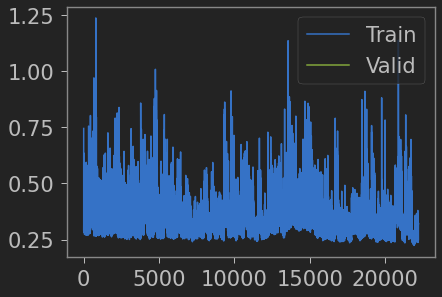

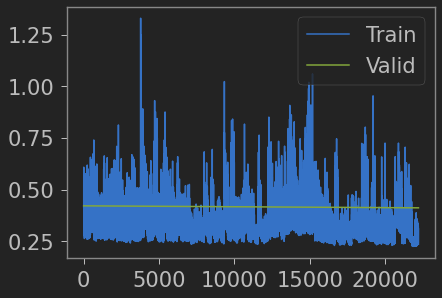

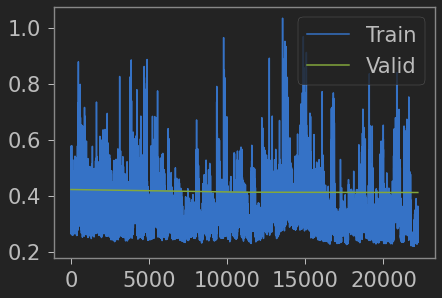

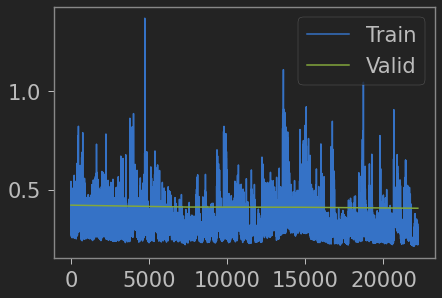

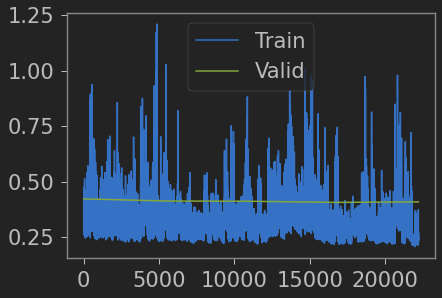

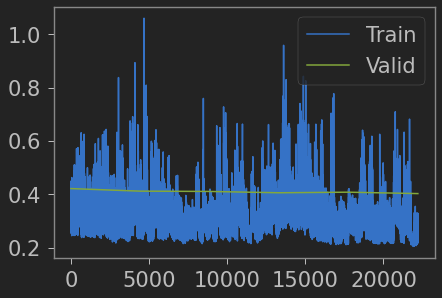

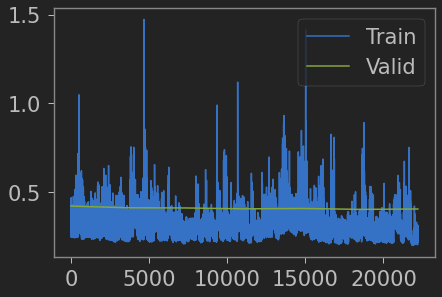

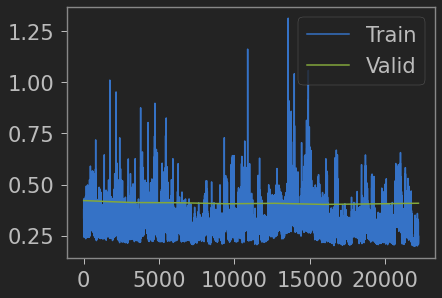

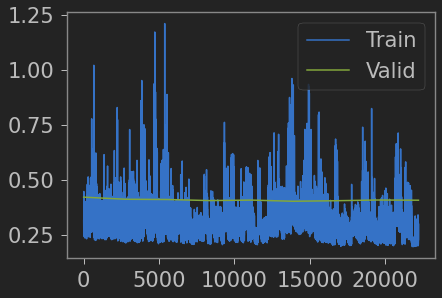

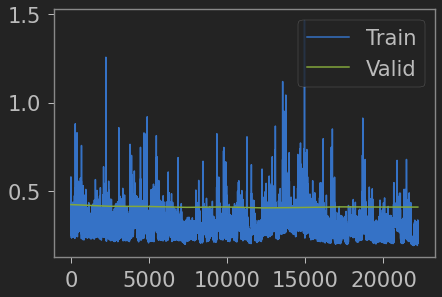

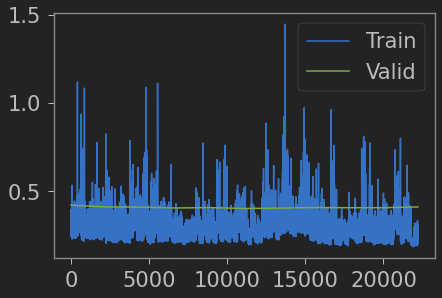

In [1]:
# Set the chart to dark mode
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False, fscale=2, figsize=(8, 6))

from main import *

if __name__ == '__main__':
    args.device = 'cuda:0'
    
    # ===== Build/Load MultiModal_SE =====
    model_name = 'S CNN512 LSTM_384_L384_L384'
    
    model = MultiModal_SE()
    model, from_epoch, valid_loss_threshold = model.load_model(
        os.path.join(args.MM_checkpoint_path, f'{model_name}.pt'),
        device=args.device
    )
#     from_epoch, valid_loss_threshold = 0, 1e9
    
    # (N, Seq, 257) -> (N, Seq, 4 * 128)
    model.S_Encoder = ResCNN(input_channel=1, input_size=Const.FBIN, use_residual=False)
        
    # (N, Seq, 124) -> (N, Seq, 12) or None
    model.E_Encoder = None
    
    # (N, Seq, 2 Encoders input size) -> (N, Seq, fusion size) or None
    model.Fusion_layer = None
    
    # (N, Seq, fusion size or S_Encoder latent size) -> (N, Seq, 257)
    model.S_Decoder = nn.Sequential(OrderedDict([
        ('lstm_4', nn.LSTM(input_size=512, hidden_size=384, bias=False, batch_first=True, dropout=0, bidirectional=False)),
        
         ('L_5', nn.Linear(384, 384, bias=False)),
        ('norm_5', nn.LayerNorm(384, elementwise_affine=True)),
        ('relu_5', nn.LeakyReLU(negative_slope=0.3)),
        
        ('L_6', nn.Linear(384, 257, bias=False)),
        ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True))
    ]))
    
    # (N, Seq, fusion size or S_Encoder latent size) -> (N, Seq, 124) or None
#     model.E_Decoder = nn.Sequential(OrderedDict([
#         ('L_6', nn.Linear(384, 124, bias=False)),
#         ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
#     ]))

    model.use_norm = True
    
    model.to(args.device)
    
    # ===== Load clean data =====
    print('Cache clean training data ...')
    dataset = cache_clean_data(split_ratio=args.split_ratio, dataset_path=args.dataset_path, device=args.device)
    print(f"Training set size: {len(dataset['Train'])}, Validation set size: {len(dataset['Valid'])}")
    
    loss_fn = nn.MSELoss()
    feat_loss_fn = None
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    
    # ===== Training =====
    print(f'Training: {model_name}')
    train(model, dataset,
          from_epoch, args.batch_size,
          valid_loss_threshold, args.loss_coef,
          loss_fn, feat_loss_fn, optimizer,
          save_filename=os.path.join(args.MM_checkpoint_path, model_name),
          dataset_path=args.dataset_path,
          use_elec=False, elec_only=False, use_zero_pad=False,
    )